 ## 1. Theory: Quantile regression



 Instead of modelling the conditional **mean** of the spillover index given the exogenous variables

 (as in OLS), quantile regression models the conditional **quantiles**:



 $$

 Q_{S_t}(\tau \mid X_t) = \beta_0(\tau) + \beta_1(\tau) x_{1,t} + \dots + \beta_K(\tau) x_{K,t},

 $$



 where:



 * $S_t$ is the endogenous variable (e.g. total spillover, or “to others”, “from others”, etc.),

 * $x_{k,t}$ are exogenous regressors (CO₂/EUA, coal, TTF, …),

 * $\tau \in (0,1)$ is the quantile of interest (e.g. $\tau = 0.1, 0.5, 0.9$),

 * $\beta_k(\tau)$ are **quantile-specific** coefficients.



 For each quantile $\tau$, the estimator solves:



 $$

 \hat\beta(\tau)

   = \arg\min_{\beta} \sum_{t}

     \rho_\tau\big(S_t - X_t' \beta \big),

 $$



 where the **check loss** is



 $$

 \rho_\tau(u) = u \big( \tau - \mathbf{1}\{u < 0\} \big).

 $$



 Intuitively:



 * For $\tau = 0.5$, quantile regression estimates the **conditional median**.

 * For $\tau < 0.5$ (e.g. 0.1), it focuses on the **lower tail** (low spillover states).

 * For $\tau > 0.5$ (e.g. 0.9), it focuses on the **upper tail** (high spillover states).



 This allows us to see whether the impact of exogenous variables (fuel prices, RES, load, …)

 is different in calm vs stressed spillover regimes.



 Below, we implement this via `statsmodels.QuantReg`, running:



 * one regression per endogenous series,

 * for a **set of quantiles** (e.g. 0.1, 0.25, 0.5, 0.75, 0.9),

 * with a flexible set of exogenous variables (you can easily add/remove variables by editing `exog_cols`).

In [1]:
# Imports and paths
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Paths
OUT_DIR = Path("../data/endogenous/prices/differenced")
endog_path = OUT_DIR / "endogenous_tsi_diff.parquet"
exog_path = Path("../data/exogenous/all_exog_ready.parquet")



In [2]:
# Helper to load parquet and convert to wide format

def load_parquet_to_wide(
    path: Path,
    date_col: str = "date",
    series_col: str = "series",
    value_col: str = "value",
) -> pd.DataFrame:
    df = pd.read_parquet(path)

    if {date_col, series_col, value_col}.issubset(df.columns):
        df[date_col] = pd.to_datetime(df[date_col])
        df_wide = df.pivot(index=date_col, columns=series_col, values=value_col).sort_index()
    else:
        if date_col not in df.columns:
            raise ValueError(
                f"'date' column not found in {path}. "
                "Add it or adapt `date_col` in load_parquet_to_wide()."
            )
        df = df.copy()
        df[date_col] = pd.to_datetime(df[date_col])
        df_wide = df.set_index(date_col).sort_index()

    df_wide.index = pd.to_datetime(df_wide.index)
    return df_wide

In [3]:
# Prepare regression data: align endogenous/exogenous and drop NAs

def prepare_regression_data(
    endog_path: Path,
    exog_path: Path,
    exog_cols: Optional[List[str]] = None,
) -> Tuple[pd.DataFrame, List[str], List[str]]:
    endog_wide = load_parquet_to_wide(endog_path)
    exog_wide = load_parquet_to_wide(exog_path)

    data = endog_wide.join(exog_wide, how="inner")

    endog_names = list(endog_wide.columns)

    if exog_cols is None:
        exog_names = list(exog_wide.columns)
    else:
        missing = [c for c in exog_cols if c not in exog_wide.columns]
        if missing:
            raise ValueError(f"Missing exogenous columns in exog data: {missing}")
        exog_names = exog_cols

    data = data[endog_names + exog_names].dropna()
    return data, endog_names, exog_names


In [4]:
# Quantile regressions + coefficient table

def run_quantile_regressions(
    data: pd.DataFrame,
    endog_names: List[str],
    exog_names: List[str],
    quantiles: List[float],
) -> Dict[Tuple[str, float], sm.regression.linear_model.RegressionResultsWrapper]:
    results = {}
    model_stats = []  # to store classical regression stats (N, R2, etc.)

    for y_col in endog_names:
        y = data[y_col]
        X = data[exog_names]
        X = sm.add_constant(X)
        model = sm.QuantReg(y, X)

        for tau in quantiles:
            res = model.fit(q=tau)
            results[(y_col, tau)] = res

            # Classical regression stats (per quantile)
            model_stats.append({
                "endog": y_col,
                "quantile": tau,
                "nobs": int(res.nobs),
                "r2": res.rsquared,
                "adj_r2": res.rsquared_adj,
                "f_stat": getattr(res, "fvalue", np.nan),
                "f_pval": getattr(res, "f_pvalue", np.nan),
                "aic": res.aic,
                "bic": res.bic,
                "dw": sm.stats.stattools.durbin_watson(res.resid),
            })

    model_stats_df = pd.DataFrame(model_stats)
    return results, model_stats_df


In [5]:
# Coefficient table for quantile regressions

def build_coef_table_qr(
    results: Dict[Tuple[str, float], sm.regression.linear_model.RegressionResultsWrapper],
    exog_names: List[str],
) -> pd.DataFrame:
    rows = []
    for (y_name, tau), res in results.items():
        for var in ["const"] + exog_names:
            rows.append(
                {
                    "endog": y_name,
                    "quantile": tau,
                    "variable": var,
                    "coef": res.params[var],
                    "std_err": res.bse[var],
                    "t": res.tvalues[var],
                    "pval": res.pvalues[var],
                    "ci_low": res.conf_int().loc[var, 0] if var in res.params.index else np.nan,
                    "ci_high": res.conf_int().loc[var, 1] if var in res.params.index else np.nan,
                }
            )

    coef_df = pd.DataFrame(rows)
    return coef_df

In [6]:
# Plot helper for one endogenous variable across quantiles

def plot_qr_coefficients_for_endog(
    coef_df: pd.DataFrame,
    endog_name: str,
    alpha: float = 0.05,
):
    subset = coef_df[coef_df["endog"] == endog_name].copy()
    subset = subset[subset["variable"] != "const"]  # skip intercept

    z = 1.96  # approx 95% CI

    fig, ax = plt.subplots(figsize=(8, 5))

    for var in subset["variable"].unique():
        tmp = subset[subset["variable"] == var].sort_values("quantile")
        coef = tmp["coef"].values
        se = tmp["std_err"].values
        q = tmp["quantile"].values

        lower = coef - z * se
        upper = coef + z * se

        ax.plot(q, coef, marker="o", label=var)
        ax.fill_between(q, lower, upper, alpha=0.15)

    ax.axhline(0.0, linestyle="--", linewidth=1)
    ax.set_title(f"Quantile regression coefficients for {endog_name}")
    ax.set_xlabel("Quantile (τ)")
    ax.set_ylabel("Coefficient")
    ax.legend()
    plt.tight_layout()
    plt.show()


Endogenous series: ['d_tsi_mhar_recov_neg', 'd_tsi_mhar_recov_pos', 'd_tsi_mhar_recov', 'd_tsi_mhar_revar']
Exogenous variables used: ['load_energy_mwh_pt', 'flow_net_mw_ES_PT', 'd_TTF', 'd_co2', 'd_coal', 'd_load_energy_mwh_es', 'd_load_energy_mwh_fr', 'd_flow_net_mw_ES_FR', 'd_cac_eur_pts', 'd_ibex_eur_pts', 'd_psi_eur_pts', 'iberian_exception']
Final sample size: 1076


C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\frolo\AppData\Lo

,endog,quantile,variable,coef,std_err,t,pval,ci_low,ci_high
0,d_tsi_mhar_recov_neg,0.10,const,-9.456891e-07,1.092395e-01,-0.000009,0.999993,-2.143505e-01,2.143486e-01
1,d_tsi_mhar_recov_neg,0.10,load_energy_mwh_pt,-1.484991e-06,7.502712e-07,-1.979273,0.048043,-2.957172e-06,-1.281050e-08
2,d_tsi_mhar_recov_neg,0.10,flow_net_mw_ES_PT,6.487803e-06,1.007545e-05,0.643922,0.519765,-1.328222e-05,2.625783e-05
3,d_tsi_mhar_recov_neg,0.10,d_TTF,-2.555416e-03,3.964394e-03,-0.644592,0.519331,-1.033434e-02,5.223511e-03
4,d_tsi_mhar_recov_neg,0.10,d_co2,4.857971e-04,6.890480e-03,0.070503,0.943807,-1.303469e-02,1.400628e-02
5,d_tsi_mhar_recov_neg,0.10,d_coal,2.882311e-04,3.075010e-03,0.093733,0.925339,-5.745549e-03,6.322011e-03
6,d_tsi_mhar_recov_neg,0.10,d_load_energy_mwh_es,1.350363e-07,7.018412e-08,1.924029,0.054618,-2.678857e-09,2.727514e-07
7,d_tsi_mhar_recov_neg,0.10,d_load_energy_mwh_fr,-1.346383e-07,4.748514e-08,-2.835379,0.004664,-2.278136e-07,-4.146310e-08
8,d_tsi_mhar_recov_neg,0.10,d_flow_net_mw_ES_FR,-1.644200e-06,8.967040e-06,-0.183360,0.854550,-1.923931e-05,1.595091e-05
9,d_tsi_mhar_recov_neg,0.10,d_cac_eur_pts,-4.496206e-05,2.317134e-04,-0.194042,0.846180,-4.996297e-04,4.097056e-04


Saved quantile regression coefficient table to: ..\data\endogenous\prices\differenced\quantile_regression_results.csv
Saved model statistics table to: ..\data\endogenous\prices\differenced\quantile_regression_model_stats.csv


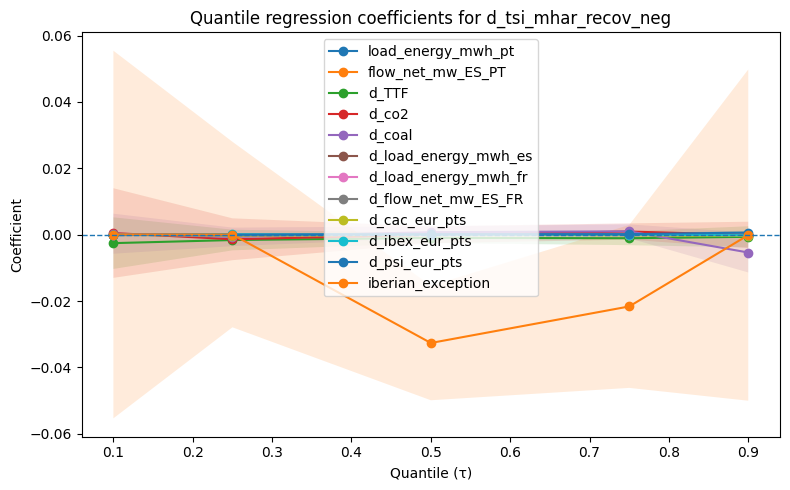

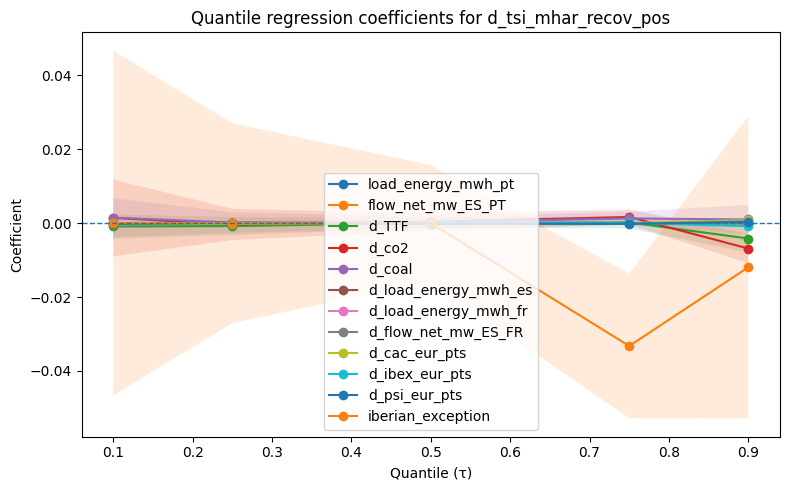

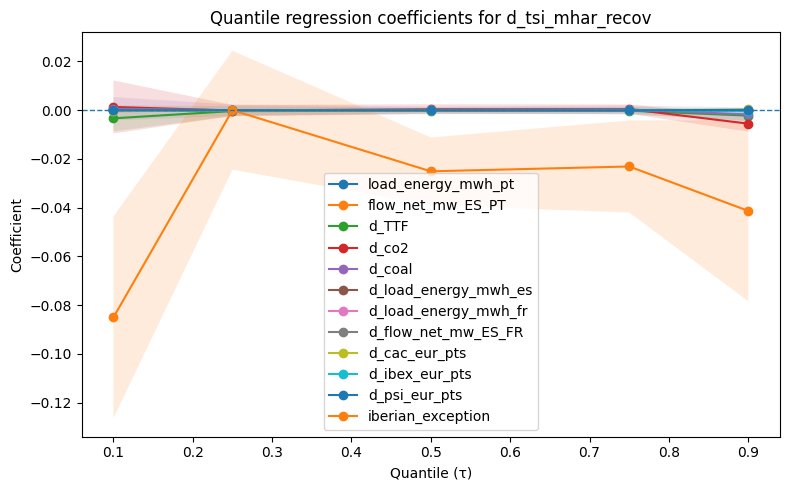

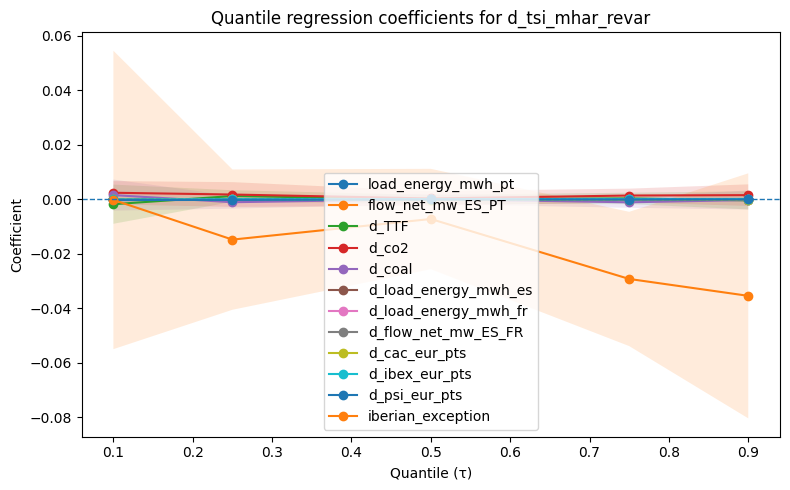

In [7]:
# Main workflow cell

# Choose which exogenous variables to use:
#   - Set exog_cols = None to use ALL exogenous columns from the parquet.
#   - Or specify a list, e.g. exog_cols = ["d_eua", "d_coal", "d_ttf"]
exog_cols = None

# Choose quantiles to estimate
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# Load and prepare data
data, endog_names, exog_names = prepare_regression_data(
    endog_path=endog_path,
    exog_path=exog_path,
    exog_cols=exog_cols,
)

print("Endogenous series:", endog_names)
print("Exogenous variables used:", exog_names)
print("Final sample size:", len(data))

# Run quantile regressions
results_qr, model_stats_df = run_quantile_regressions(
    data=data,
    endog_names=endog_names,
    exog_names=exog_names,
    quantiles=quantiles,
)

# Build coefficient table
coef_qr_df = build_coef_table_qr(results_qr, exog_names)
display(coef_qr_df.head(20))

# Save coefficient table
OUT_DIR.mkdir(parents=True, exist_ok=True)
out_coef_path_qr = OUT_DIR / "quantile_regression_results.csv"
coef_qr_df.to_csv(out_coef_path_qr, index=False)
print(f"Saved quantile regression coefficient table to: {out_coef_path_qr}")

# Save model statistics (N, R², Adj R², AIC, etc.)
out_model_stats_path = OUT_DIR / "quantile_regression_model_stats.csv"
model_stats_df.to_csv(out_model_stats_path, index=False)
print(f"Saved model statistics table to: {out_model_stats_path}")

# Example plots for each endogenous series
for y_name in endog_names:
    plot_qr_coefficients_for_endog(coef_qr_df, y_name)
